In [27]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from math import e
from joblib import dump, load
import statistics as st
from calendar import isleap

#### Historical ERA5 t2m

In [28]:
#Surface data
t2mData = xr.open_dataset('../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_t2m_daily_NovDecJan.nc')
#d2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_d2m_daily_NovDecJan.nc')
# Read Orography
OroData = xr.open_dataset('../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5IGP_Orography.nc')

t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86)).t2m
OroD = OroData.sel(latitude=slice(32,24),longitude=slice(74,86))


# create mask
oro = OroD.z
oro.values = OroD.z.values/9.81
oro.attrs
oro.attrs['units']='meter'
oro.attrs['long_name']='Orography'
oro.values[oro.values>500.1]=np.NaN
mask=oro.values/oro.values

/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3223: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(


<xarray.DataArray 'rh' (dayofyear: 63)>
array([1.66323078, 1.83572519, 1.76773071, 1.71856761, 1.80421472,
       1.71097922, 1.77927756, 1.72364128, 1.7611779 , 1.79292572,
       1.67954195, 1.70938885, 1.76490057, 1.61215258, 1.5393995 ,
       1.67036951, 1.84318364, 1.86340547, 1.73402357, 1.54451787,
       1.67987823, 1.76847374, 1.67513144, 1.63224137, 1.55268419,
       1.67570102, 1.76589322, 1.74070525, 1.62049091, 1.59564734,
       1.56805086, 0.9323895 , 1.06505871, 1.11437309, 1.09976602,
       1.1976428 , 1.17830884, 1.20104778, 1.22446251, 1.36070931,
       1.37961757, 1.43409312, 1.46032941, 1.34491205, 1.3702203 ,
       1.44628334, 1.51153088, 1.49506605, 1.42585504, 1.41931331,
       1.45528877, 1.52181423, 1.32922137, 1.17746174, 1.20519578,
       1.31616509, 1.3204515 , 1.36280167, 1.32649696, 1.17072344,
       1.11025071, 1.45031703, 1.10783851])
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

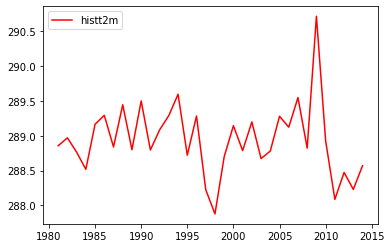

In [29]:

rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), t2mD)}, coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})

# apply mask
rh_ds.rh.values=rh_ds.rh.values*mask

# Area Average
rhTS1=rh_ds.mean(dim=['latitude','longitude'], skipna=True).rh

rhTs=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))
# # Historical Moisture
x=np.arange(1981,2015)
ObsERA5=[]
#print(rhTs.time)
for yr in x :
    InDString=np.datetime64(str(yr-1)+'-12-01T09:00:00')
    EnDString=np.datetime64(str(yr)+'-01-31T09:00:00')
   # print(EnDString)
    rhT=rhTs.sel(time=slice(InDString,EnDString))
    #print(rhT.time)
    ObsERA5.append(rhT.mean())
    
    #print(yr)

#print(y)
plt.plot(x,ObsERA5,label='histt2m', color='red')
plt.legend()


rhHistMean1=rhTs.groupby('time.dayofyear').mean()
rhHistMean2=rhHistMean1.roll(dayofyear=31)
histRH=rhHistMean2[(rhHistMean2.dayofyear<366) | (rhHistMean2.dayofyear>366)]

rhERA5HistMean=rhTs.groupby('time.dayofyear').mean()
rhERA5HistMean
rhERA5HistStd=rhTs.groupby('time.dayofyear').std()
rhERA5HistStd


[278.98987 279.03506 278.84814 ... 278.4597  278.1823  278.50937]


/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3223: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(


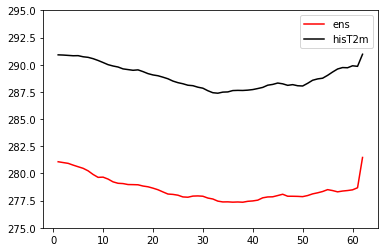

In [30]:
### Historical model BC

# IPSL

rhData  = xr.open_dataset('../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_tas_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')
rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
rhTsIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))

# EC-Earth3
rhData  = xr.open_dataset('../../Data/CMIP6/EC-Earth3/processed/Regrid_tas_day_EC-Earth3_historical_r1i1p1f1_gr_18500101-20141231.nc')
rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
rhTsEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))


# ACCESS-CM2

rhData  = xr.open_dataset('../../Data/CMIP6/ACCESS-CM2/tasNHRegrid_NDJFday_ACCESS-CM2_historical_r1i1p1f1_gn_19500101-20141231.nc')
rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
rhTsACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))



MTs=[rhTsIPSL,rhTsEC,rhTsACCESS]

MS=np.array(MTs)
meanMS=np.mean(MS, axis=0)
print(meanMS)

ensTs=rhTs.copy()
ensTs.values=meanMS


# # Historical Moisture
x=np.arange(1,63)
rhHistMean1=ensTs.groupby('time.dayofyear').mean()
rhHistMean2=rhHistMean1.roll(dayofyear=31)
histRH_ens=rhHistMean2[(rhHistMean2.dayofyear<366) | (rhHistMean2.dayofyear>366)]
plt.plot(x,histRH_ens,label='ens', color='red')
plt.plot(x,histRH,label='hisT2m', color='black')

plt.ylim([275, 295])
plt.legend()




In [31]:
# # Historica/ref best3 ensemble mean and std



MTs=[rhTsIPSL,rhTsEC,rhTsACCESS]

MS=np.array(MTs)
meanMS=np.mean(MS, axis=0)
print(meanMS)

ensTs=rhTs.copy()
ensTs.values=meanMS

ensTsMean=ensTs.groupby('time.dayofyear').mean()
ensTsStd=ensTs.groupby('time.dayofyear').std()
ensTsMean


[278.98987 279.03506 278.84814 ... 278.4597  278.1823  278.50937]


<xarray.DataArray 'rh' (dayofyear: 63)>
array([277.73657, 277.6492 , 277.45374, 277.37888, 277.3866 , 277.35825,
       277.37555, 277.35284, 277.43585, 277.4716 , 277.54297, 277.75833,
       277.8374 , 277.85138, 277.96622, 278.08572, 277.90366, 277.90103,
       277.89093, 277.86664, 277.96658, 278.12057, 278.21802, 278.337  ,
       278.5105 , 278.4247 , 278.3074 , 278.3811 , 278.4275 , 278.49194,
       278.68265, 281.46912, 281.07565, 281.0002 , 280.92795, 280.7655 ,
       280.61606, 280.47226, 280.23962, 279.9065 , 279.64005, 279.65918,
       279.48184, 279.22546, 279.09497, 279.06738, 278.97882, 278.97037,
       278.9563 , 278.84192, 278.77286, 278.64722, 278.50064, 278.2993 ,
       278.1057 , 278.07184, 277.99936, 277.83963, 277.813  , 277.91626,
       277.93222, 277.9033 , 277.35062], dtype=float32)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

278.551160326191


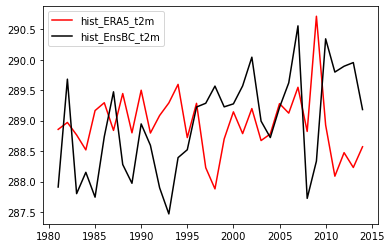

In [32]:
### Historical Bias Correction


MTs=[]
for c in rhTsACCESS.time:
        
    MTs.append((rhTsACCESS.sel(time=c)+rhTsIPSL.sel(time=c)+
                rhTsEC.sel(time=c))/3.0)
    
ensFu=rhTsACCESS.copy()
ensFu.values=MTs


MS=np.array(MTs)
meanMS=np.mean(MS, axis=0)
print(meanMS)

ensFu=rhTsACCESS.copy()
ensFu.values=MTs

ensFuMean=ensFu.groupby('time.dayofyear').mean()
ensFuStd=ensFu.groupby('time.dayofyear').std()

### Change factor

BC=[]


for d in ensFu.time:
    t=pd.Period(d.values, freq='H').dayofyear
    yr=d.dt.year.values
    if(isleap(yr) & t>334 ):
        t=t-1
    
    BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    

#ensFuBC=np.array(BC)

ensFuBC = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
#print(ensFuBC)
#print(ensFu)

#print(ensFuBC)
#print(cnnObs)


x=np.arange(1981,2015)
EnsBCHist=[]
#print(rhTs.time)
for yr in x :
    InDString=np.datetime64(str(yr-1)+'-12-01T12:00:00')
    EnDString=np.datetime64(str(yr)+'-01-31T12:00:00')
   # print(EnDString)
    rhT=ensFuBC.sel(time=slice(InDString,EnDString))
   # print(rhT.time)
    EnsBCHist.append(rhT.mean().values)
    
    #print(yr)

#print(y)

plt.plot(x,ObsERA5,label='hist_ERA5_t2m', color='red')
plt.plot(x,EnsBCHist,label='hist_EnsBC_t2m', color='black')
plt.legend()



/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3223: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


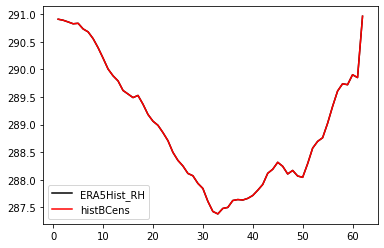

In [33]:
x=np.arange(1,63)
plt.plot(x,histRH,label='ERA5Hist_RH', color='black')
ensFuBCHistMean1=ensFuBC.groupby('time.dayofyear').mean()
ensFuBCHistMean2=ensFuBCHistMean1.roll(dayofyear=31)
histBCens=ensFuBCHistMean2[(ensFuBCHistMean2.dayofyear<366) | (ensFuBCHistMean2.dayofyear>366)]
plt.plot(x,histBCens,label='histBCens', color='red')
plt.legend()
plt.savefig('histEnsBCTS.eps')
plt.show()

df=ensFuBC.to_dataframe(name='histEnsBCTS')
#np.savetxt('histEnsTS.txt', df.values, fmt='%1.3f')



In [34]:
######### Future proj

In [35]:
ssps=['126','245','370','585']

fig = plt.figure(figsize=(10,7))
x=np.arange(1981,2015)
#plt.plot(x,ObsERA5,label='hist_ERA5_t2m')
plt.plot(x,EnsBCHist,label='Historical')
for sp in ssps:

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF
    
    xFu=np.arange(2015,2101)
    EnsBCFu=[]
#print(rhTs.time)
    for yr in xFu :
        InDString=np.datetime64(str(yr-1)+'-12-01T12:00:00')
        EnDString=np.datetime64(str(yr)+'-01-31T12:00:00')
   # print(EnDString)
        rhT=ensFuBCF.sel(time=slice(InDString,EnDString))
   # print(rhT.time)
        EnsBCFu.append(rhT.mean())
    
    plt.plot(xFu,EnsBCFu,label='SSP'+sp)


plt.legend()

plt.xlabel('Year') 
plt.ylabel('2m temperature K')

plt.savefig('t2m_ts.eps')
plt.show()
    
    #print(yr)


#fig, axs = plt.subplots(1,4,figsize=(10,7))
fig = plt.figure(figsize=(22.5,5))

i=1
for sp in ssps:

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF
    x=np.arange(1981,2015)
#plt.plot(x,ObsERA5,label='hist_ERA5_t2m')
    plt.subplot(1, 4, i)

    plt.plot(x,EnsBCHist,label='Historical',color='black')
    
    xFu=np.arange(2015,2101)
    EnsBCFu=[]
#print(rhTs.time)
    for yr in xFu :
        InDString=np.datetime64(str(yr-1)+'-12-01T12:00:00')
        EnDString=np.datetime64(str(yr)+'-01-31T12:00:00')
   # print(EnDString)
        rhT=ensFuBCF.sel(time=slice(InDString,EnDString))
   # print(rhT.time)
        EnsBCFu.append(rhT.mean())
    
    plt.plot(xFu,EnsBCFu,label='SSP'+sp,color='black')
    plt.title('SSP'+sp)
    if i==1:
        plt.ylabel('2m temperature K')
    plt.ylim(285,298)
    plt.axvline(x=2014,color='grey')
    i=i+1
    


#plt.legend()

#plt.xlabel('Year') 
#plt.ylabel('2m temperature K')

plt.savefig('t2m_ts_panel.eps')
plt.show()
    
    #print(yr)


#fig, axs = plt.subplots(1,4,figsize=(10,7))
fig = plt.figure(figsize=(22.5,5))

i=1
for sp in ssps:

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF
    x=np.arange(1981,2015)
#plt.plot(x,ObsERA5,label='hist_ERA5_t2m')
    plt.subplot(1, 4, i)

    #plt.plot(x,EnsBCHist,label='Historical',color='black')
    plt.plot(x,EnsBCHist,label='hist_ERA5_rh',color='grey')
    S = pd.Series (EnsBCHist)
    rENS=S.rolling(5, center=True, min_periods=1).mean()
    plt.plot(x,rENS,label='hist_ERA5_rh',color='black')
    
    xFu=np.arange(2015,2101)
    EnsBCFu=[]
#print(rhTs.time)
    for yr in xFu :
        InDString=np.datetime64(str(yr-1)+'-12-01T12:00:00')
        EnDString=np.datetime64(str(yr)+'-01-31T12:00:00')
   # print(EnDString)
        rhT=ensFuBCF.sel(time=slice(InDString,EnDString))
   # print(rhT.time)
        EnsBCFu.append(rhT.mean())
    plt.plot(xFu,EnsBCFu,label='SSP'+sp,color='grey')
    S = pd.Series (EnsBCFu)
    rENS=S.rolling(5, center=True, min_periods=1).mean()
    plt.plot(xFu,rENS,label='SSP'+sp,color='black')
    plt.title('SSP'+sp)
    if i==1:
        plt.ylabel('2m temperature K')
    plt.ylim(285,298)
    plt.axvline(x=2014,color='black',linestyle=':')
    i=i+1
    


#plt.legend()

#plt.xlabel('Year') 
#plt.ylabel('2m temperature K')

plt.savefig('t2m_ts_panel_5yMean.eps')
plt.show()
    
    #print(yr)


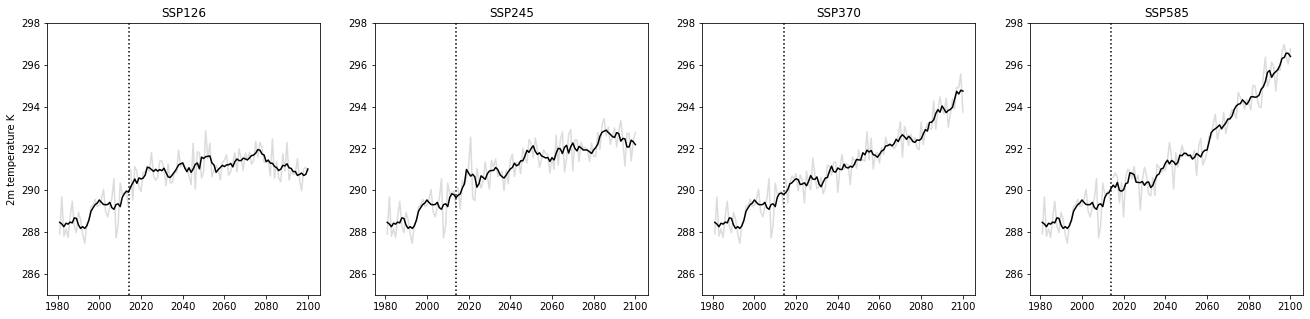

In [37]:
#fig, axs = plt.subplots(1,4,figsize=(10,7))
fig = plt.figure(figsize=(22.5,5))

i=1
for sp in ssps:
    x=np.arange(1981,2015)
    
    plt.subplot(1, 4, i)

    plt.plot(x,EnsBCHist,label='hist_ERA5_rh',color='gainsboro')

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF
    
    #S = pd.Series (EnsBCHist)
    #rENS=S.rolling(10, center=True, min_periods=1).mean()
    #plt.plot(x,rENS,label='hist_ERA5_rh',color='black')
    
    xFu=np.arange(2015,2101)
    EnsBCFu=[]
#print(rhTs.time)
    for yr in xFu :
        InDString=np.datetime64(str(yr-1)+'-12-01T12:00:00')
        EnDString=np.datetime64(str(yr)+'-01-31T12:00:00')
   # print(EnDString)
        rhT=ensFuBCF.sel(time=slice(InDString,EnDString))
   # print(rhT.time)
        EnsBCFu.append(rhT.mean())
    
    plt.plot(xFu,EnsBCFu,label='SSP'+sp,color='gainsboro')
    jointList=EnsBCHist+EnsBCFu
    S = pd.Series (jointList)
    xTotal=np.arange(1981,2101)
    rENS=S.rolling(5, center=True, min_periods=1).mean()
    plt.plot(xTotal,rENS,label='SSP'+sp,color='black')
    plt.title('SSP'+sp)
    if i==1:
        plt.ylabel('2m temperature K')
    plt.ylim(285,298)
    plt.axvline(x=2014,color='black',linestyle=':')
    i=i+1
    


#plt.legend()

#plt.xlabel('Year') 
#plt.ylabel('2m temperature K')

plt.savefig('t2m_ts_panel_5yMean.eps')
plt.show()
    
    #print(yr)


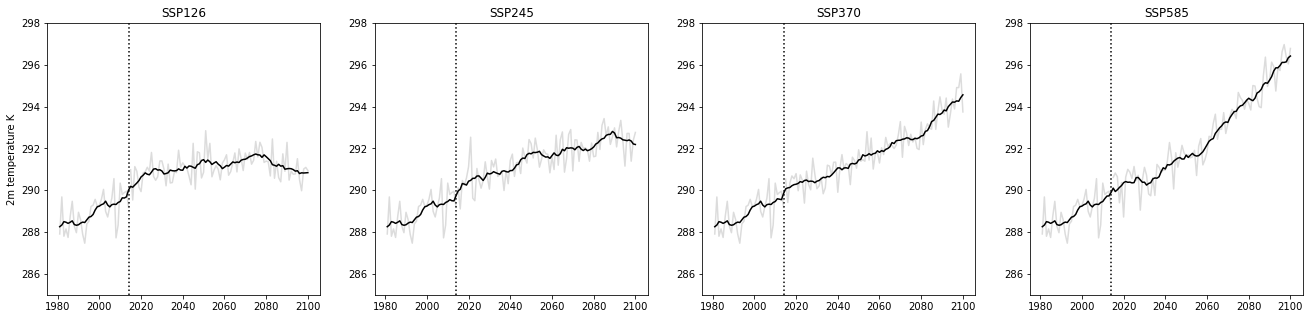

In [38]:
#fig, axs = plt.subplots(1,4,figsize=(10,7))
fig = plt.figure(figsize=(22.5,5))

i=1
for sp in ssps:
    x=np.arange(1981,2015)
    
    plt.subplot(1, 4, i)

    plt.plot(x,EnsBCHist,label='hist_ERA5_rh',color='gainsboro')

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    rhData=xr.open_dataset(folderString+'Regrid_tas_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    rhD  = rhData.tas.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2100-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF
    
    #S = pd.Series (EnsBCHist)
    #rENS=S.rolling(10, center=True, min_periods=1).mean()
    #plt.plot(x,rENS,label='hist_ERA5_rh',color='black')
    
    xFu=np.arange(2015,2101)
    EnsBCFu=[]
#print(rhTs.time)
    for yr in xFu :
        InDString=np.datetime64(str(yr-1)+'-12-01T12:00:00')
        EnDString=np.datetime64(str(yr)+'-01-31T12:00:00')
   # print(EnDString)
        rhT=ensFuBCF.sel(time=slice(InDString,EnDString))
   # print(rhT.time)
        EnsBCFu.append(rhT.mean())
    
    plt.plot(xFu,EnsBCFu,label='SSP'+sp,color='gainsboro')
    jointList=EnsBCHist+EnsBCFu
    S = pd.Series (jointList)
    xTotal=np.arange(1981,2101)
    rENS=S.rolling(10, center=True, min_periods=1).mean()
    plt.plot(xTotal,rENS,label='SSP'+sp,color='black')
    plt.title('SSP'+sp)
    if i==1:
        plt.ylabel('2m temperature K')
    plt.ylim(285,298)
    plt.axvline(x=2014,color='black',linestyle=':')
    i=i+1
    


#plt.legend()

#plt.xlabel('Year') 
#plt.ylabel('2m temperature K')

plt.savefig('t2m_ts_panel_10yMean.eps')
plt.show()
    
    #print(yr)
